## Import dependencies

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import numpyro
import jax
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO

import vbjax

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
** shtns is not available


## Setup the model

Now we can setup a single sphere field model and run a simulation:

In [3]:
# local coupling
lmax, nlat, nlon = 31, 32, 64
lc = vbjax.make_shtdiff(lmax=lmax, nlat=nlat, nlon=nlon)

# initial conditions
x0 = jax.random.normal(jax.random.PRNGKey(42), (nlat, nlon))
x1 = lc(x0)

# time grid & coupling strength
ts = jnp.r_[:100]*0.01
_, run = vbjax.make_ode(0.01, lambda x, k: -x + k*lc(x))
k = 1.0

# simulated time series
xt = run(x0, ts, k)

Next we construct a simple sum squared loss function, of the model against its own time series:

In [3]:
@jax.jit
def loss(x0h):
    xth = run(x0h, ts, k)
    sse = jnp.sum(jnp.square(xt - xth))
    return sse

x0h = jnp.ones_like(x0)
assert loss(x0) == 0.0
assert loss(x0h) > 0

We can check some timings to see how long individual gradients take:

In [4]:
g = jax.jit(jax.grad(loss))
g(x0h);
%timeit run(x0h, ts, k)
%timeit g(x0h)

4.71 ms ± 17.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.3 ms ± 31 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now we have a working model set up, we can create a specific parameter map to recover:

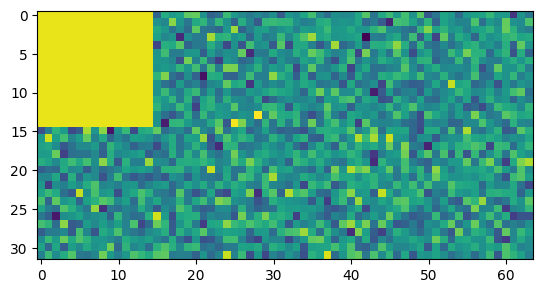

In [5]:
x0 = x0.at[:15,:15].set(3.0)
imshow(x0)

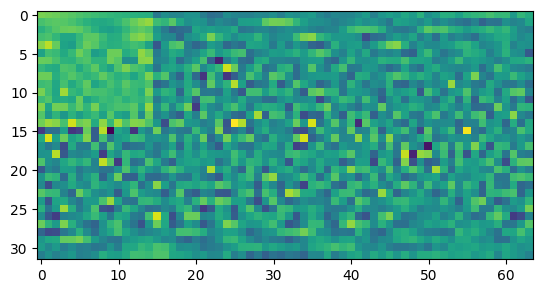

In [6]:
xt = run(x0, ts, k)
imshow(xt[99])

To use NumPyro we need a target function,

In [7]:
import numpyro.distributions as dist

and we adapt our model with some priors,

In [8]:
def logp(xt=None):
    x0h = numpyro.sample('x0h', dist.Normal(jnp.zeros((nlat, nlon)), 1))
    xth_mu = run(x0h, ts, k)
    numpyro.sample('xth', dist.Normal(xth_mu, 1), obs=xt)

and run an MCMC chain w/ NUTS

In [ ]:
nuts_kernel = NUTS(logp)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=500)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, xt=xt)

sample:  82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [07:51<02:12,  1.39it/s, 63 steps of size 9.85e-02. acc. prob=0.85]

## Diagnostics

One of the simplest diagnostics is to check that the true values are likely given our posterior,

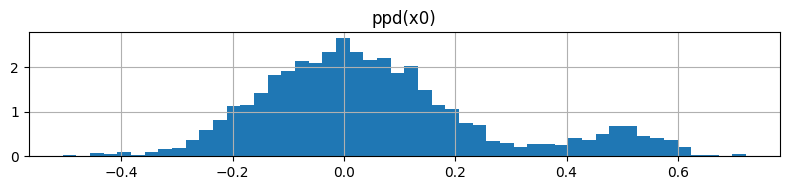

In [11]:
samples = mcmc.get_samples()
x0h = samples['x0h']

figure(figsize=(8, 2))
hist(((x0 - x0h.mean(axis=0))/x0h.std(axis=0)).reshape(-1), 50, density=True)
title('ppd(x0)');
grid(1)
tight_layout()

The true values are z-scored by the posterior, and since they're centered around 0, we can conclude the chain recovered correct values.